In [1]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import pickle
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Function to downsample (select either mean or RMS), and normalize the data

def downsample(df):
    index_list = df.index.tolist() # index_list to store index

    col, row = np.shape(df)

    l = []

    R = 1000 # window size

    # create a list with a ndarray of each sample, broken up into 1000 segment chunks
    # from here: https://stackoverflow.com/questions/20322079/downsample-a-1d-numpy-array     
    for i in range(col):
        a = df.iloc[i].to_numpy(dtype='float32')        
        a.reshape(-1, R)
        l.append(a.reshape(-1, R))


    # index through chunks to create RMS values
#     signals = []
#     for i in range(col):
#         t = l[i]
#         temp = []

#         for j in range(int(row/R)):
#             temp.append(np.sqrt(np.mean(np.square(t[j,:],dtype=np.float32)))) # Need to convert to float32
            
#         signals.append(temp)
        
    
    # Use this to just do MEAN value downsampling
    signals = []
    for i in range(col):
        t = l[i]
        temp = []

        for j in range(int(row/R)):
            temp.append(np.mean(t[j,:],dtype=np.float32)) # Need to convert to float32
            
        signals.append(temp)
      
    return pd.DataFrame(signals,index=index_list).to_numpy()

def normalizer(a,min_val,max_val):
    # min-max scaling if wanted
    # https://codereview.stackexchange.com/questions/185785/scale-numpy-array-to-certain-range
    col, row = np.shape(a)
    for i in range(col):
        a[i] = np.interp(a[i], (min_val, max_val), (-1, +1))
    return a

**Load and downsample the train data. Min-max normalization**

In [7]:
%%time
# Downsample df_train
path = '/home/tim/Documents/PD-Predictions/data/raw'
os.listdir(path)
file_path = os.path.join(path,"train.parquet")


df_train = pq.read_pandas(os.path.join(path,file_path)).to_pandas()
df_train = df_train.T
df_train = df_train.reset_index(drop=True)

df_train = downsample(df_train)

#all_train to pickle
all_train = df_train
pickle_out = open("all_train_mean_NOSCALE.pickle","wb")
pickle.dump(all_train, pickle_out)
pickle_out.close()

CPU times: user 7min 28s, sys: 19.3 s, total: 7min 47s
Wall time: 6min 53s


In [8]:
df_train = pd.DataFrame(df_train)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,17.962656,17.794971,17.886559,17.607101,17.667654,18.013689,17.815582,17.758039,17.243086,17.044472,...,18.566610,18.560738,18.594004,18.466158,18.456354,18.296585,18.342056,18.140507,17.930672,17.915051
1,0.964883,0.974679,1.070514,1.006976,1.240564,1.903943,2.139626,2.626785,2.563981,2.846401,...,2.868623,2.505594,2.267598,2.222611,1.971801,1.804162,1.289574,1.040673,0.889382,0.970052
2,18.902355,19.381487,19.537886,20.158199,20.375303,20.138420,20.599806,20.617201,21.060627,20.842314,...,17.488367,17.353155,17.315889,17.687849,17.845980,18.142242,18.209833,18.718468,19.098429,19.094109
3,15.997343,15.845472,15.556092,15.591023,15.267711,15.136347,14.928496,14.751474,14.744389,14.241313,...,17.480389,17.192179,17.211130,17.043356,16.826557,16.840160,16.415876,16.468031,16.076069,15.947194
4,5.091758,5.311779,5.319398,5.698158,5.661448,5.958020,6.094424,6.193464,6.550725,6.488220,...,3.310891,3.272614,3.637169,3.835362,4.001625,4.366349,4.289872,4.795936,4.791868,5.080945


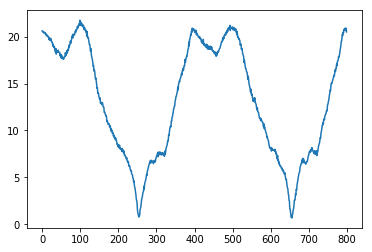

In [24]:
# Quick visulization
i = 56
plt.plot(df_train.iloc[i,:])

**Split the df_extra into 3 and save as parquet files. Normalize only after adding all_train and all_extra together**

In [3]:
path = '/home/tim/Documents/PD-Predictions/data/raw'
df_extra = pq.read_pandas(os.path.join(path,os.path.join(path,"test.parquet"))).to_pandas()

df_extra1 = df_extra.iloc[:,:6779]
df_extra2 = df_extra.iloc[:,6779:13558]
df_extra3 = df_extra.iloc[:,13558:]

import pyarrow as pa
table = pa.Table.from_pandas(df_extra1)
pq.write_table(table, 'df_extra1.parquet')

table = pa.Table.from_pandas(df_extra2)
pq.write_table(table, 'df_extra2.parquet')

table = pa.Table.from_pandas(df_extra3)
pq.write_table(table, 'df_extra3.parquet')



**Load the df_extra dataframes and create downsampled pickles**

In [3]:
%%time
path = '/home/tim/Documents/PD-Predictions/data/raw'
print(os.listdir(path))

# file to downsample. e.g. df_train1
file_name = "df_extra3.parquet"
df_extra = pq.read_pandas(os.path.join(path,os.path.join(path,file_name))).to_pandas()
df_extra = df_extra.T #transpose
df_extra = df_extra.reset_index(drop=True) #drop index, don't care


df_extra = downsample(df_extra)

#df_extra to pickle
pickle_out = open("df_extra3_RMS_NOSCALE.pickle","wb")
pickle.dump(df_extra, pickle_out)
pickle_out.close()

['sample_submission.csv', 'df_extra1.parquet', 'metadata_test.csv', 'df_extra2.parquet', 'metadata_train.csv', 'train.parquet', 'df_extra3.parquet', 'test.parquet']
CPU times: user 5min 49s, sys: 14.6 s, total: 6min 3s
Wall time: 5min 17s


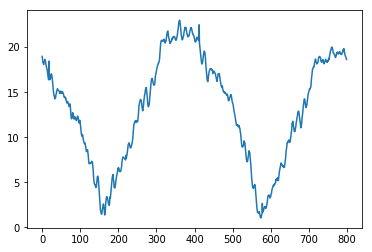

In [6]:
i = 14
plt.plot(df_extra[i])

**Run this to get the train/val/test sets**

In [25]:
path = '/home/tim/Documents/PD-Predictions/data/raw'
df_train_label = pd.read_csv(os.path.join(path,"metadata_train.csv")).reset_index(drop=True)
df_train_label.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [26]:
# join the label and data df
df_train = df_train.join(df_train_label,how='left')
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,794,795,796,797,798,799,signal_id,id_measurement,phase,target
0,17.962656,17.794971,17.886559,17.607101,17.667654,18.013689,17.815582,17.758039,17.243086,17.044472,...,18.456354,18.296585,18.342056,18.140507,17.930672,17.915051,0,0,0,0
1,0.964883,0.974679,1.070514,1.006976,1.240564,1.903943,2.139626,2.626785,2.563981,2.846401,...,1.971801,1.804162,1.289574,1.040673,0.889382,0.970052,1,0,1,0
2,18.902355,19.381487,19.537886,20.158199,20.375303,20.138420,20.599806,20.617201,21.060627,20.842314,...,17.845980,18.142242,18.209833,18.718468,19.098429,19.094109,2,0,2,0
3,15.997343,15.845472,15.556092,15.591023,15.267711,15.136347,14.928496,14.751474,14.744389,14.241313,...,16.826557,16.840160,16.415876,16.468031,16.076069,15.947194,3,1,0,1
4,5.091758,5.311779,5.319398,5.698158,5.661448,5.958020,6.094424,6.193464,6.550725,6.488220,...,4.001625,4.366349,4.289872,4.795936,4.791868,5.080945,4,1,1,1


In [27]:
# separate the "clean" signals (label=0) from PD signals (label=1)
df_train_target0 = df_train[df_train['target']==0]
df_train_target1 = df_train[df_train['target']==1]

In [28]:
# how to split df https://code.i-harness.com/en/q/247a8d6
def train_validate_test_split(df, train_percent=0.8, validate_percent=0.1, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

In [29]:
# randomly shuffle the PD signals and store all in train1
train1, validate1, test1 = train_validate_test_split(df_train_target1, 
                                                  train_percent=1, 
                                                  validate_percent=0, 
                                                  seed=5)

# randomly shuffle the "clean" signals and store in train0
train0, validate0, test0 = train_validate_test_split(df_train_target0, 
                                                  train_percent=1, 
                                                  validate_percent=0, 
                                                  seed=5)

# select 525 samples from "clean" training set so we can add it to PD training set
# df_pretrain = train0.iloc[525:]
train0 = train0.iloc[0:525]

# create
df_train_temp = pd.concat([train0, train1])

train, validate, test = train_validate_test_split(df_train_temp, 
                                                  train_percent=0.7, 
                                                  validate_percent=0.15, 
                                                  seed=12)

In [30]:
# delete df_train_temp from memory
del df_train_temp
del train0
del train1
del df_train_target0
del df_train_target1

**Create X_train, y_train sets, and pickles**

In [31]:
X_train = train.drop(labels=['signal_id','id_measurement','phase','target'],axis=1).to_numpy()
y_train = train['target'].to_numpy()

X_val = validate.drop(labels=['signal_id','id_measurement','phase','target'],axis=1).to_numpy()
y_val = validate['target'].to_numpy()

X_test = test.drop(labels=['signal_id','id_measurement','phase','target'],axis=1).to_numpy()
y_test = test['target'].to_numpy()

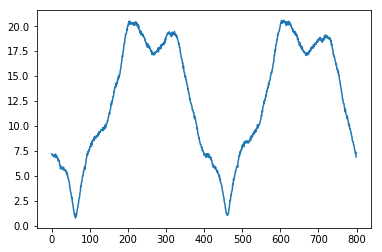

In [32]:
i = 14
plt.plot(X_test[i])
plt.show()

In [33]:
import pickle

#X_train
pickle_out = open("X_train.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

#X_val
pickle_out = open("X_val.pickle","wb")
pickle.dump(X_val, pickle_out)
pickle_out.close()

#X_test
pickle_out = open("X_test.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

#y_train-127
pickle_out = open("y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

#y_val
pickle_out = open("y_val.pickle","wb")
pickle.dump(y_val, pickle_out)
pickle_out.close()

#y_test
pickle_out = open("y_test.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()